In [1]:
#Importing needed libraries
import pandas as pd
import cv2
import numpy as np
import glob
import random
import os.path
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import image
from keras.models import Sequential, Model
from keras.layers import MaxPooling2D, Conv2D, Activation, Dropout, Dense, Flatten

# Data Preparation

In [2]:
class_names = ['CORROSION', 'CRACKED', 'GOOD']
nb_classes = len(class_names)
image_size = (120,120)
num_epoch = 5

In [3]:
Train_Data_Path = Path('./PIPES/TRAIN')
Test_Data_Path = Path('./PIPES/TEST')

In [4]:
Train_JPG_Path = list(Train_Data_Path.glob(r"**/*.jpg"))
Test_JPG_Path = list(Test_Data_Path.glob(r"**/*.jpg"))

In [5]:
Train_JPG_Labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1],Train_JPG_Path))
Test_JPG_Labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1],Test_JPG_Path))

In [6]:
#converting all the values to series
Train_JPG_Path_Series = pd.Series(Train_JPG_Path,name="JPG").astype(str)
Train_JPG_Labels_Series = pd.Series(Train_JPG_Labels,name="CATEGORY").tolist()
Test_JPG_Path_Series = pd.Series(Test_JPG_Path,name="JPG").astype(str)
Test_JPG_Labels_Series = pd.Series(Test_JPG_Labels,name="CATEGORY").tolist()

In [7]:
def convertlabels(y):
    labels=[]
    for i in range (0,len(y)):
            if y[i]=="CORROSION": labels.append(0)
            elif y[i]=="CRACKED": labels.append(1)
            else: labels.append(2)
    labels=np.array(labels)
    return labels

def convertimage(path):
    images=[]
    for i in path:
        image = cv2.imread(i)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, image_size)
        images.append(image)
    return np.array(images)

In [8]:
X_train=convertimage(Train_JPG_Path_Series)
X_test=convertimage(Test_JPG_Path_Series)
Y_train=convertlabels(Train_JPG_Labels_Series)
Y_test=convertlabels(Test_JPG_Labels_Series)

In [9]:
X_train,Y_train=shuffle(X_train,Y_train,random_state=10)
X_test,Y_test=shuffle(X_test,Y_test,random_state=10)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train = X_train/255
X_test = X_test/255

print("X_train shape", X_train.shape)
print("y_train shape", Y_train.shape)
print("X_test shape", X_test.shape)
print("y_test shape", Y_test.shape)

X_train shape (4500, 120, 120, 3)
y_train shape (4500,)
X_test shape (1050, 120, 120, 3)
y_test shape (1050,)


# Building the model

In [10]:
model = Sequential()

model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(120,120, 3), strides=(1,1), padding="valid"))
model.add(MaxPooling2D((2, 2),strides=(2,2), padding="valid"))

model.add(Conv2D(32, (3, 3), activation='relu', strides=(1,1), padding="valid"))
model.add(MaxPooling2D((2, 2), strides=(2,2), padding="valid"))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu', strides=(1,1), padding="valid"))
model.add(MaxPooling2D((2, 2), strides=(2,2), padding="valid"))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(128, activation='relu')) 
model.add(Dropout(0.25))
model.add(Dense(3, activation='softmax'))

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 118, 118, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 59, 59, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 57, 57, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 28, 28, 32)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 28, 28, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 26, 26, 64)        1

In [12]:
model.compile(optimizer='adam',loss='SparseCategoricalCrossentropy',
              metrics=['accuracy'])

In [13]:
history = model.fit(X_train, Y_train, epochs=num_epoch, 
                    validation_split=0.2)

Epoch 1/5
113/113 [==============================] - 102s 762ms/step - loss: 0.5284 - accuracy: 0.7603 - val_loss: 0.3057 - val_accuracy: 0.8700
Epoch 2/5
113/113 [==============================] - 92s 808ms/step - loss: 0.1306 - accuracy: 0.9525 - val_loss: 0.0246 - val_accuracy: 0.9922
Epoch 3/5
113/113 [==============================] - 96s 852ms/step - loss: 0.0242 - accuracy: 0.9919 - val_loss: 0.0108 - val_accuracy: 0.9967
Epoch 4/5
113/113 [==============================] - 100s 892ms/step - loss: 0.0244 - accuracy: 0.9911 - val_loss: 0.0064 - val_accuracy: 1.0000
Epoch 5/5
113/113 [==============================] - 96s 846ms/step - loss: 0.0111 - accuracy: 0.9956 - val_loss: 0.0031 - val_accuracy: 1.0000


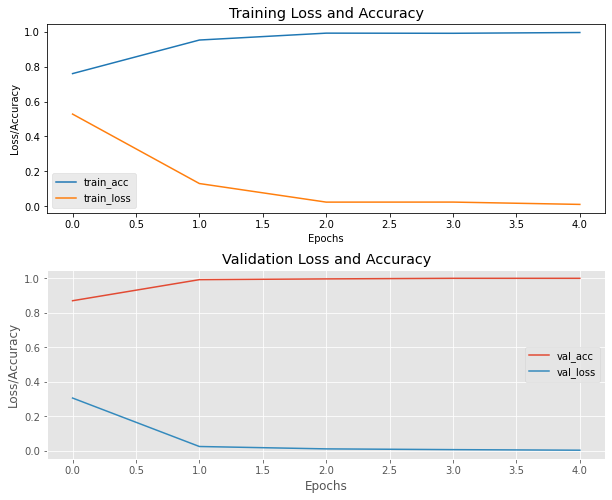

In [14]:
#Plotting the train accuracy
plt.figure(figsize=(8,8))
plt.subplot(2,1,1)
plt.subplots_adjust(hspace=0.3)
plt.style.use("ggplot")
plt.plot(np.arange(0, num_epoch), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, num_epoch), history.history["loss"], label="train_loss")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Loss/Accuracy")
plt.legend()

plt.subplot(2,1,2)
plt.plot(np.arange(0, num_epoch), history.history["val_accuracy"], label="val_acc")
plt.plot(np.arange(0, num_epoch), history.history["val_loss"], label="val_loss")
plt.title("Validation Loss and Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Loss/Accuracy")
plt.legend()

In [15]:
# Evaluating the model on test and train data to finding the loss and accuracy
results = model.evaluate(X_test, Y_test)
# Accuracy and loss for test dataset
print("Loss of the model  while using  test dataset", results[0])
print("Accuracy of the model while using  test dataset", results[1]*100, "%")
results = model.evaluate(X_train, Y_train)
# Accuracy and loss for Train dataset
print("Loss of the model  while using  train dataset", results[0])
print("Accuracy of the model while using  train dataset", results[1]*100, "%")

33/33 [==============================] - 7s 213ms/step - loss: 0.1137 - accuracy: 0.9590
Loss of the model  while using  test dataset 0.11372224241495132
Accuracy of the model while using  test dataset 95.90476155281067 %
141/141 [==============================] - 38s 272ms/step - loss: 0.0035 - accuracy: 1.0000
Loss of the model  while using  train dataset 0.0034934140276163816
Accuracy of the model while using  train dataset 100.0 %


models.save_model(model,'IV4PMmodel.h5') #saving the model

model = models.load_model('IV4PMmodel.h5') #loading the model

model.save_weights('./IV4PM_weights')

In [16]:
predIdxs = model.predict(X_test)
label = ["CORROSION","CRACKED","GOOD"]

predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(Y_test, predIdxs,target_names=label))

33/33 [==============================] - 11s 310ms/step
              precision    recall  f1-score   support

   CORROSION       1.00      0.88      0.93       350
     CRACKED       0.89      1.00      0.94       350
        GOOD       1.00      1.00      1.00       350

    accuracy                           0.96      1050
   macro avg       0.96      0.96      0.96      1050
weighted avg       0.96      0.96      0.96      1050



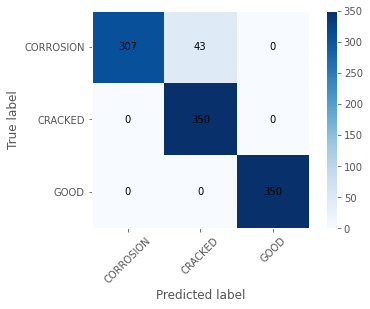

In [17]:
cm = confusion_matrix(Y_test, predIdxs)

# Plot confusion matrix
plt.imshow(cm,interpolation='none',cmap='Blues')
plt.grid(False)
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

for (i, j), z in np.ndenumerate(cm):
    plt.text(j, i, z, ha='center', va='center')
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

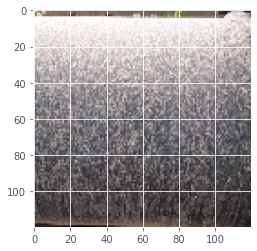

1/1 [==============================] - 0s 25ms/step
Our model says it's : GOOD


In [35]:
df2 = random.randint(0, len(Y_test))
plt.imshow(X_test[df2, :])
plt.show()

y_pred = model.predict(X_test[df2, :].reshape(1,120,120,3))
y_pred = np.argmax(y_pred)
if y_pred == 0:
    pred = 'CORROSION'
elif y_pred == 1:
    pred = 'CRACKED'
else:
    pred = 'GOOD'
print('Our model says it\'s : {}'.format(pred))

# Using SVM as Classifier

In [19]:
from sklearn.svm import SVC
model_feat = Model(inputs=model.input,outputs=model.get_layer('dense').output)
feat_train = model_feat.predict(X_train)
feat_test = model_feat.predict(X_test)

1/1 [==============================] - 0s 28ms/step
Our model says it's : GOOD
33/33 [==============================] - 6s 176ms/step


In [20]:
svm = SVC(kernel='rbf')
svm.fit(feat_train,Y_train)

SVC()

In [21]:
y_predsvm = svm.predict(feat_test)
print(accuracy_score(Y_test,y_predsvm))

0.9638095238095238


In [22]:
# Check the accuracy
print(classification_report(Y_test, y_predsvm))

              precision    recall  f1-score   support

           0       1.00      0.89      0.94       350
           1       0.90      1.00      0.95       350
           2       1.00      1.00      1.00       350

    accuracy                           0.96      1050
   macro avg       0.97      0.96      0.96      1050
weighted avg       0.97      0.96      0.96      1050



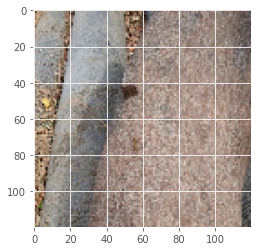

1/1 [==============================] - 0s 48ms/step
Our model says it's : GOOD


In [23]:
df2 = random.randint(0, len(Y_test))#Randomly select from the test dataset
plt.imshow(X_test[df2, :])
plt.show()

y_predsvm = model.predict(X_test[df2, :].reshape(1,120,120,3))#predict
y_predsvm = np.argmax(y_predsvm)
if y_pred == 0:
    pred = 'CORROSION'
elif y_pred == 1:
    pred = 'CRACKED'
else:
    pred = 'GOOD'
print('Our model says it\'s : {}'.format(pred))

# Using Decision Tree

In [24]:
from sklearn.tree import DecisionTreeClassifier
model_feat = Model(inputs=model.input,outputs=model.get_layer('dense').output)
feat_traindt = model_feat.predict(X_train)
feat_testdt = model_feat.predict(X_test)

33/33 [==============================] - 5s 158ms/step


In [25]:
dt = DecisionTreeClassifier(criterion = "entropy", random_state = 100,max_depth=3, min_samples_leaf=5)
dt.fit(feat_traindt,Y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_leaf=5,
                       random_state=100)

In [26]:
dt.score(feat_testdt,Y_test)

0.9647619047619047

In [27]:
# Check the accuracy
y_preddt = dt.predict(feat_testdt)
print(classification_report(Y_test, y_preddt))

              precision    recall  f1-score   support

           0       1.00      0.89      0.94       350
           1       0.90      1.00      0.95       350
           2       1.00      1.00      1.00       350

    accuracy                           0.96      1050
   macro avg       0.97      0.96      0.96      1050
weighted avg       0.97      0.96      0.96      1050



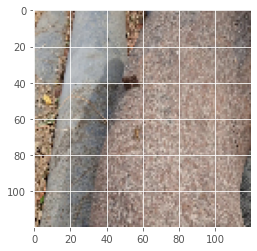

1/1 [==============================] - 0s 45ms/step
Our model says it's : CORROSION


In [28]:
df2 = random.randint(0, len(Y_test))#Randomly select from the test dataset
plt.imshow(X_test[df2, :])
plt.show()

y_preddt = model.predict(X_test[df2, :].reshape(1,120,120,3))#predict
y_preddt = np.argmax(y_preddt)
if y_preddt == 0:
    pred = 'CORROSION'
elif y_preddt == 1:
    pred = 'CRACKED'
else:
    pred = 'GOOD'
print('Our model says it\'s : {}'.format(pred))

# Using k Nearest neighbor

In [29]:
from sklearn.neighbors import KNeighborsClassifier
model_feat = Model(inputs=model.input,outputs=model.get_layer('dense').output)
feat_traink = model_feat.predict(X_train)
feat_testk = model_feat.predict(X_test)

33/33 [==============================] - 6s 168ms/step


In [30]:
knn = KNeighborsClassifier(n_neighbors=12)
knn.fit(feat_traink,Y_train)

KNeighborsClassifier(n_neighbors=12)

In [31]:
knn.score(feat_testk,Y_test)

0.9657142857142857

In [32]:
# Check the accuracy
y_predk = knn.predict(feat_testk)
print(classification_report(Y_test, y_predk))

              precision    recall  f1-score   support

           0       1.00      0.90      0.95       350
           1       0.91      1.00      0.95       350
           2       1.00      1.00      1.00       350

    accuracy                           0.97      1050
   macro avg       0.97      0.97      0.97      1050
weighted avg       0.97      0.97      0.97      1050



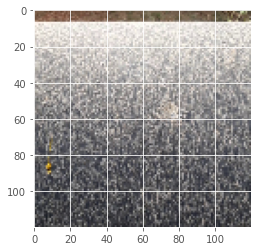

1/1 [==============================] - 0s 24ms/step
Our model says it's : GOOD


In [33]:
df2 = random.randint(0, len(Y_test))#Randomly select from the test dataset
plt.imshow(X_test[df2, :])
plt.show()

y_predk = model.predict(X_test[df2, :].reshape(1,120,120,3))#predict
y_predk = np.argmax(y_predk)
if y_predk == 0:
    pred = 'CORROSION'
elif y_predk == 1:
    pred = 'CRACKED'
else:
    pred = 'GOOD'
print('Our model says it\'s : {}'.format(pred))

# Using ANN

#Performing Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

#Initialising ANN
ann = tf.keras.models.Sequential() 
ann.add(tf.keras.layers.Dense(units=6,activation="relu")) #Adding First Hidden Layer
ann.add(tf.keras.layers.Dense(units=6,activation="relu"))#Adding Second Hidden Layer
ann.add(tf.keras.layers.Dense(units=1,activation="sigmoid"))#Adding Output Layer


ann.compile(optimizer="adam",loss="binary_crossentropy",metrics=['accuracy'])#Compiling ANN

#Fitting ANN
ann.fit(X_train,Y_train,batch_size=32,epochs = 10)